# DLthon - 길찾는 오리들
## Base Settings

In [1]:
# importing the libraries
import keras, tensorflow as tf
from keras import layers

# keras.mixed_precision.set_global_policy('mixed_float16')

# importing the modules
import models_base, models_top, utils

2025-01-24 15:58:16.442550: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 15:58:16.451499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737701896.464476   46421 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737701896.467703   46421 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 15:58:16.479731: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_unified_datasets("data/data_blue_sorted")

Found 374 files belonging to 6 classes.
Using 300 files for training.
Using 74 files for validation.


I0000 00:00:1737552426.929717  551156 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
# designing the model

def eV2L_midsize3(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    x = utils.image_preprocessing_v1()(inputs)
    x = models_base.EV2L((224, 224, 3))(x, training=False)
    x = models_top.midsize1()(x)
    outputs = layers.Dense(6, activation='softmax', name="classifier")(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
                   metrics=['accuracy'])
    
    return model

eV2L_midsize3().summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_preprocessing_v1          │ (None, 224, 224, 3)    │             7 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_midsize1 (Sequential)     │ (None, 256)            │     1,049,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,798,253 (453.18 MB)

 Trainable params: 1,051,398 (4.01 MB)

 Non-trainable params: 117,746,855 (449.17 MB)

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_preprocessing_v1          │ (None, 224, 224, 3)    │             7 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_midsize3 (Functional)     │ (None, 256)            │     4,594,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,342,829 (466.70 MB)

 Trainable params: 4,594,950 (17.53 MB)

 Non-trainable params: 117,747,879 (449.17 MB)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.2456 - loss: 2.0576 - val_accuracy: 0.3594 - val_loss: 1.7274
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3853 - loss: 1.5556 - val_accuracy: 0.4531 - val_loss: 1.7089
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5236 - loss: 1.3226 - val_accuracy: 0.5781 - val_loss: 1.6910
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5777 - loss: 1.1584 - val_accuracy: 0.5938 - val_loss: 1.6659
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6026 - loss: 1.0989 - val_accuracy: 0.5469 - val_loss: 1.6470
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6406 - loss: 1.0315 - val_accuracy: 0.6094 - val_loss: 1.6198
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6959 - loss: 0.8692 - val_accuracy: 0.5938 - val_loss: 1.6038
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7244 - loss: 0.8284 - val_accuracy: 0.7188 - val_loss: 1.5746
Epoch 

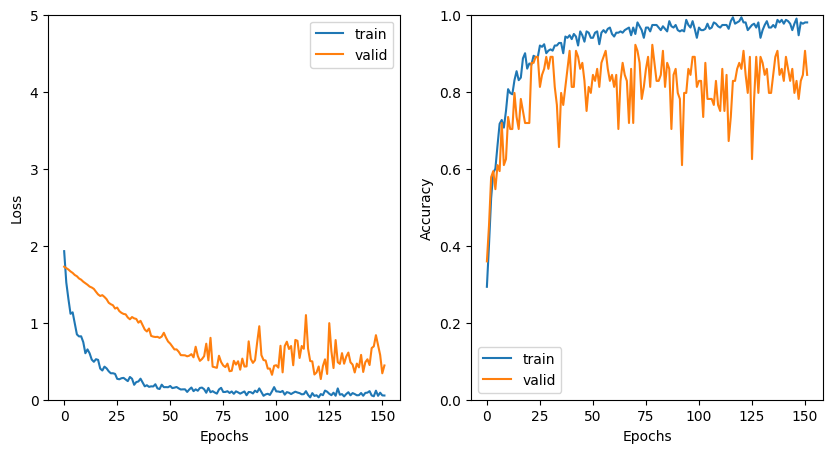

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9000 - loss: 0.4139
Test accuracy: 0.90%, Test loss: 0.41


In [11]:
eV2L_midsize3_history = eV2L_midsize3().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_midsize3.keras'),
        utils.callback_earlystop(30)
    ],
)

utils.plot_history(eV2L_midsize3_history)

In [12]:
test_loss, test_acc = keras.models.load_model('eV2L_midsize3.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9000 - loss: 0.4139
Test accuracy: 0.90%, Test loss: 0.41


In [8]:
# loading the dataset
train_more, val_more, test_more = utils.load_unified_datasets("More_Data_Set")

Found 6000 files belonging to 6 classes.
Using 3600 files for training.
Using 2400 files for validation.


In [11]:
eV2L_midsize3_more_history = eV2L_midsize3().fit(
    train_more,
    validation_data=val_more,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_midsize3_more.keras'),
        utils.callback_earlystop(30)
    ],
)

utils.plot_history(eV2L_midsize3_history)

test_loss, test_acc = keras.models.load_model('eV2L_midsize3_more.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

Epoch 1/200


I0000 00:00:1737702190.987287   46724 cuda_dnn.cc:529] Loaded cuDNN version 90600


36/57 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - accuracy: 0.3056 - loss: 1.6205

KeyboardInterrupt: 

In [6]:
# This script needs these libraries to be installed:
#   tensorflow, numpy

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import random
import numpy as np
import tensorflow as tf


# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project-test",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 512,
        "activation_1": "relu",
        "dropout": random.uniform(0.01, 0.80),
        "layer_2": 10,
        "activation_2": "softmax",
        "optimizer": "sgd",
        "loss": "categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 8,
        "batch_size": 256
    }
)

# [optional] use wandb.config as your config
config = wandb.config

# designing the model

def eV2L_simple2(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    x = utils.image_preprocessing_v1()(inputs)
    x = models_base.EV2L((224, 224, 3))(x, training=False)
    x = models_top.simple2()(x)
    outputs = layers.Dense(6, activation='softmax', name="classifier")(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss=config.loss,
                   optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                   metrics=[config.metric])
    
    return model

eV2L_simple2().summary()

eV2L_midsize1_history = eV2L_midsize1().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_midsize1.keras'),
        utils.callback_earlystop(30),
        WandbMetricsLogger(),
        WandbModelCheckpoint("models.keras"),
    ],
)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Found 5000 files belonging to 5 classes.
Using 3000 files for training.
Using 2000 files for validation.
